In [23]:
#first get the python modules we need
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.convolution import convolve, Box1DKernel
from astropy.table import Table
import astropy.units as u
from astropy.modeling import models, fitting


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
lines = [8498.02,8542.09,8662.14]
path = '/home/david/work/1144_lt/spectra/nicola_2/WDJ114404.76+052951.77/' #note the / on the end

vispath = path + 'VIS_notell/'
sp = glob.glob(vispath+'*TAC.csv')

In [49]:
line_list = Table.read('line_positions.ecsv')

In [50]:
len(line_list[line_list['Xs'] !=  -1.0])

24

In [51]:
line_list = line_list[line_list['Xs'] !=  -1.0]

In [52]:
sp_lines, xs = line_list['FILENAME'], line_list['Xs']

In [59]:
def get_shifted_lines(x, lines):
    #calculates the approximate positions of the shifted lines
    rest_lam = lines[0]*u.AA
    obs_lam = x*u.AA
    dv = obs_lam.to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam))
    #print(dv)
    l2 = dv.to(u.AA, equivalencies=u.doppler_optical(lines[1]*u.AA))
    l3 = dv.to(u.AA, equivalencies=u.doppler_optical(lines[2]*u.AA))
    return np.array([x, l2.value, l3.value])

def make_plot_spec(w, f, mask1, mask2): #cuts spectrum down to the bit to plot
    #mask = (w > 8450) & (w < 8480) | (w > 8520) & (w <8540) | (w > 8560) & (w< 8660) | (w > 8680) & (w < 8700) #mask out emmission lines
    w1, f1 = w[mask1], f[mask1]
    n_init = models.Polynomial1D(3)
    n_fit = fitter(n_init, w1, f1)
    #mask = (w > 8450) & (w < 8700)
    w1, f1 = w[mask2], f[mask2]
    nf = f1/n_fit(w1)
    nf = convolve(nf,Box1DKernel(10))
    return w1,nf
    
    
def dv_average(dvs, es):
    """
    Returns a variance-weighted dv with standard error of the weighted mean (variance weights, scale corrected).
    
    """
    weights = 1 / (es**2)
    dv = np.average(dvs, weights = weights)
    var = 1 / np.sum(weights)
    rcs = np.sum((((dv - dvs)**2) * weights)) / (len(dvs)-1) #reduced chi-squared
    error = (var * rcs)**0.5
    return dv, error
#get_shifted_lines(xs[0], lines)

In [60]:
fitter = fitting.LevMarLSQFitter()
dvs = []
dves = []
dates = []
for s, x in zip(sp_lines, xs):
   # print(s)
    w, f, e = np.loadtxt(s, unpack=True, delimiter=',')
    slines = get_shifted_lines(x, lines)
    mask1 = (w > 8450) & (w < slines[0]-5) | (w > slines[0]+5) & (w <slines[1]-5) | (w > slines[1]+5) & (w< slines[2]-5) | (w > slines[2]+5) & (w < 8700)
    mask2 = (w> 8460) & (w < 8690) 
    w, f =  make_plot_spec(w, f, mask1, mask2)
    #plt.plot(w, f)
    date = fits.getheader(s[:-3]+'fits')['MJD-OBS']
    dates.append(date)
    
    
   # plt.figure()
    for i in range(len(lines)):
        line = lines[i]
        guess = slines[i]
        if i == 0:
            gg_init = models.Const1D(1.0)+models.Gaussian1D(1.0, guess,1.0)    
        else:
            gg_init = gg_init + models.Gaussian1D(1.0, guess, 1.0)
     #  plt.axvline(line, c='r', ls='--')
    gg_fit = fitter(gg_init, w, f, maxiter=1000)
    fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
    #print(gg_fit)
    #print(fit_e)
   # plt.plot(w, f)
   # plt.plot(w, gg_fit(w))
   # plt.show()
    obs_lines = [gg_fit[1].mean*u.AA, gg_fit[2].mean*u.AA, gg_fit[3].mean*u.AA]
    obs_e = [fit_e[2]*u.AA, fit_e[5]*u.AA, fit_e[8]*u.AA]
    dv = [obs_lam.to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam*u.AA)).value for obs_lam, rest_lam in zip(obs_lines, lines)]
    
    e_up = [(obs_lam+e_lam).to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam*u.AA)).value for obs_lam, e_lam, rest_lam in zip(obs_lines, obs_e, lines)]
    e_down = [(obs_lam-e_lam).to(u.km/u.s,  equivalencies=u.doppler_optical(rest_lam*u.AA)).value for obs_lam, e_lam, rest_lam in zip(obs_lines, obs_e, lines)]
    e_up = np.array([abs(e-d) for e, d in zip(e_up, dv)])
    e_down = np.array([abs(e-d) for e, d in zip(e_down, dv)])
    es = np.mean([e_up, e_down], axis=0)
    #print(len(es))
    dv, dve = dv_average(dv, es)
    dvs.append(dv)
    dves.append(dve)
    
    #dvs.append(np.mean(dv))
    #print(np.std(dv))
    
    

<ErrorbarContainer object of 3 artists>

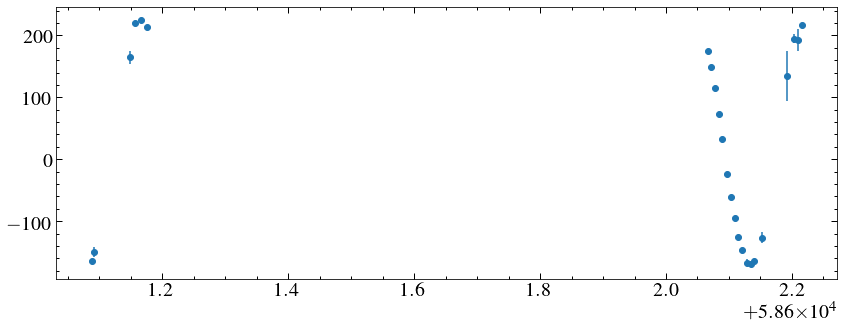

In [61]:
plt.errorbar(dates, dvs, yerr=dves, marker='o', ls='none')

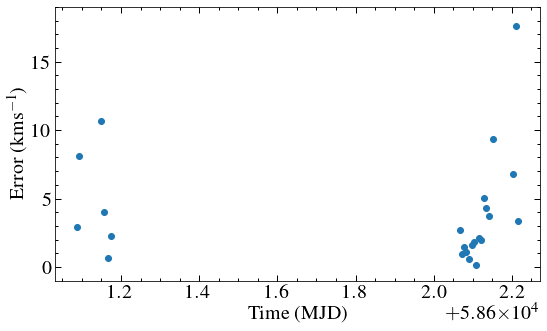

In [71]:
plt.figure(figsize=(8,5))
plt.errorbar(dates, dves, marker='o', ls='none')
plt.ylim(-1, 19)
plt.xlabel('Time (MJD)')
plt.ylabel('Error (kms$^{-1}$)')
plt.tight_layout()
plt.savefig('errortest.png')

In [72]:
from astropy.timeseries import LombScargle

In [76]:

dates = np.array(dates) + (150/86400)
args = np.argsort(dates)

In [78]:
t = dates[args]
dvs = np.array(dvs)[args]
dves= np.array(dves)[args]
t = (t-t[0])*24

<ErrorbarContainer object of 3 artists>

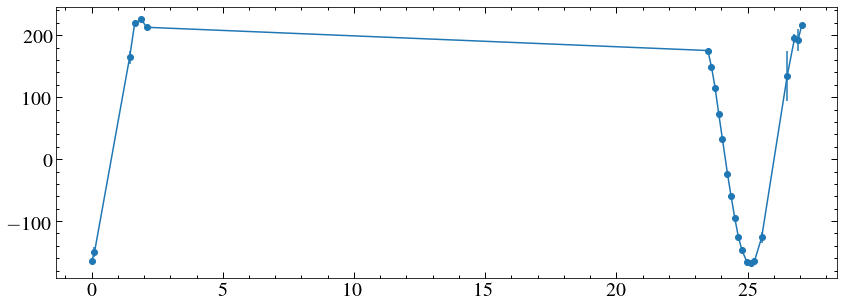

In [81]:
plt.errorbar(t, dvs, yerr=dves, marker='o')

4.219081272084805


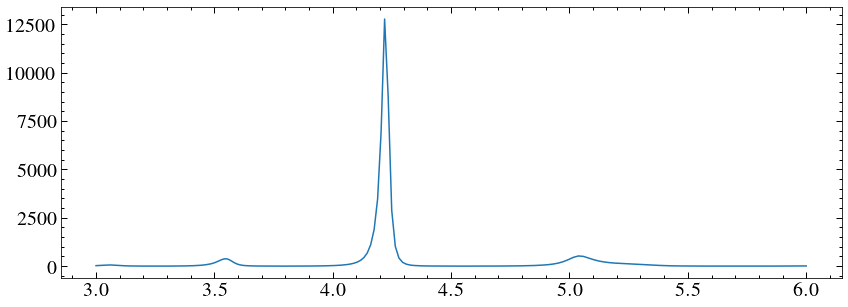

In [118]:
frequency = np.linspace(1/6, 1/3, 200)
power = LombScargle(t, dvs, dves, normalization='model').power(frequency)#.autopower(minimum_frequency =1/4.5, maximum_frequency = 1/3.8)#frequency)
plt.plot(1/frequency, power)
#plt.xlim(2,10)
period = 1/frequency[np.argmax(power)]
print(period)

<ErrorbarContainer object of 3 artists>

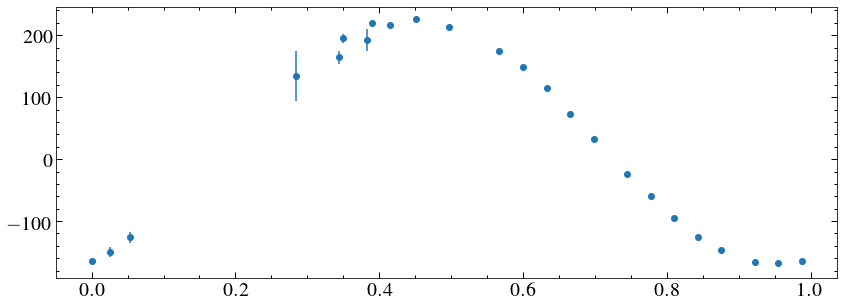

In [120]:
t_fold = (t/period) %1
plt.errorbar(t_fold, dvs, yerr=dves, marker='o', ls='none')

Inequality constraints incompatible    (Exit mode 4)
            Current function value: 483448.6605638175
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
Model: CompoundModel1265
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Const1D(amplitude=27.)>

    [1]: <Sine1D(amplitude=190., frequency=0.23640662, phase=0.)>
Parameters:
    amplitude_0 amplitude_1     frequency_1     phase_1
    ----------- ----------- ------------------- -------
           27.0       190.0 0.23640661938534277     0.0
4.23


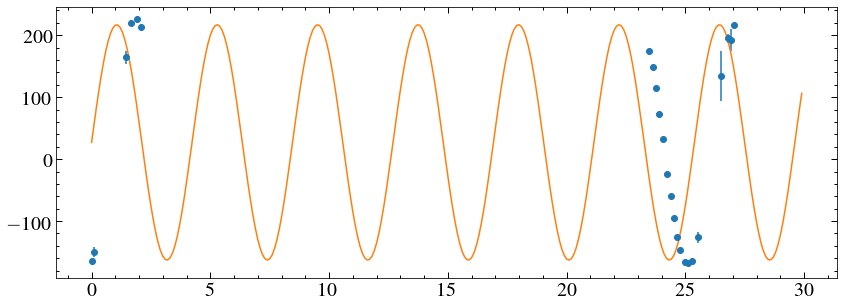

In [220]:
fitter = fitting.SLSQPLSQFitter()
sine_mod =  models.Const1D(27, bounds=dict(amplitude=[0, 60])) + models.Sine1D(amplitude=190, frequency=1/4.23, bounds=dict(amplitude=[170, 250], frequency=[1/5, 1/3]))
sine_fit = fitter(sine_mod, t, dvs, maxiter=100)
print(sine_fit)
plt.errorbar(t, dvs, yerr=dves, marker='o', ls='none')
#phase_t = np.arange(0,1.01, 0.01 )
#plt.plot(phase_t, sine_fit(phase_t))
t_plot = np.arange(0, 30, 0.1)
plt.plot(t_plot, sine_fit(t_plot))
print(1/sine_fit[1].frequency)

In [150]:
print (max(dvs) - abs(min(dvs)))
print(max(dvs - ))

57.07217344284493
168.49639907776464


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 847.1029314938169
            Iterations: 11
            Function evaluations: 81
            Gradient evaluations: 11
Model: CompoundModel1296
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Const1D(amplitude=57.)>

    [1]: <Sine1D(amplitude=150., frequency=1., phase=0.)>
Parameters:
       amplitude_0      amplitude_1    frequency_1      phase_1      
    ----------------- ---------------- ----------- ------------------
    27.58817094391605 196.797157672191         1.0 -4104.202617612528


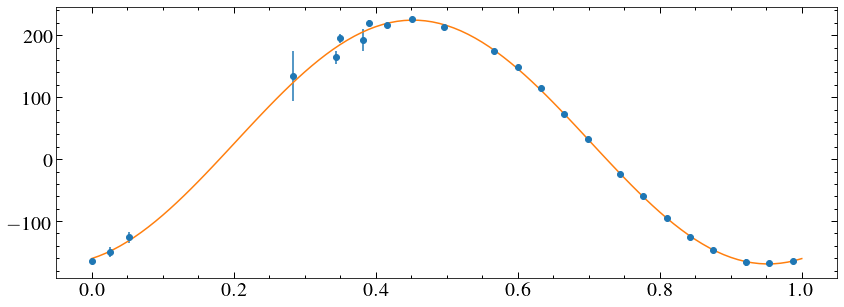

In [259]:
fitter = fitting.SLSQPLSQFitter()
#fitter = fitting.LevMarLSQFitter()

sine_mod =  models.Const1D(57, bounds=dict(amplitude=[0, 60])) + models.Sine1D(amplitude=150, frequency=1, bounds=dict(amplitude=[100, 200]), fixed=dict(frequency=1))
sine_fit = fitter(sine_mod, t_fold, dvs, maxiter=100000)
print(sine_fit)
plt.errorbar(t_fold, dvs, yerr=dves, marker='o', ls='none')
phase_t = np.arange(0,1.01, 0.01 )
plt.plot(phase_t, sine_fit(phase_t))
#t_plot = np.arange(0, 30, 0.1)
#plt.plot(t_plot, sine_fit(t_plot))

Model: CompoundModel1284
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Const1D(amplitude=57.)>

    [1]: <Sine1D(amplitude=150., frequency=1., phase=0.)>
Parameters:
       amplitude_0    amplitude_1 frequency_1       phase_1      
    ----------------- ----------- ----------- -------------------
    36.76844516954981       170.0         1.0 0.08410091508869247


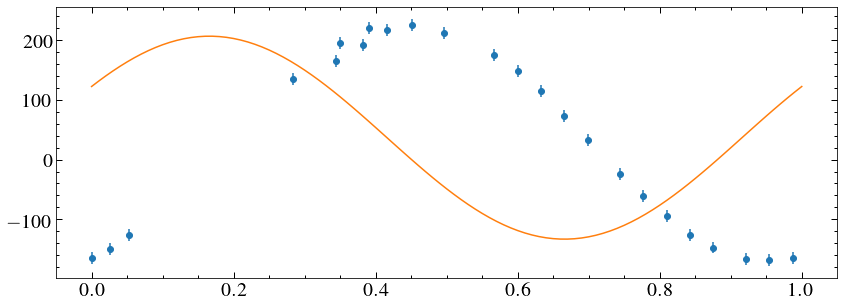

In [247]:
fitter = fitting.SLSQPLSQFitter()
fitter = fitting.LevMarLSQFitter()
errs = np.full(len(t_fold), 10)
sine_mod =  models.Const1D(57, bounds=dict(amplitude=[0, 60])) + models.Sine1D(amplitude=150, frequency=1, bounds=dict(amplitude=[170, 250]), fixed=dict(frequency=1))
sine_fit = fitter(sine_mod, t_fold, dvs, errs, maxiter=10000)
print(sine_fit)
plt.errorbar(t_fold, dvs, yerr=errs, marker='o', ls='none')
phase_t = np.arange(0,1.01, 0.01 )
plt.plot(phase_t, sine_fit(phase_t))
#t_plot = np.arange(0, 30, 0.1)
#plt.plot(t_plot, sine_fit(t_plot))

Can't deal with errors for some reason